In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from bio_if.data.utils import FastaDataset, GB1_IDX

In [3]:
splits = ['train', 'val', 'test']
df = pd.DataFrame(columns=['seq', 'label', 'split'])
for split in splits:
    dataset = FastaDataset("../../src/bio_if/data/FLIP/gb1/two_vs_rest.fasta", split=split)
    df_to_append = pd.DataFrame([(''.join(i[k] for k in GB1_IDX), j.item(), split) for i, j in dataset], columns=['seq', 'label', 'split'])
    df = pd.concat([df, df_to_append])
# fix the index
df = df.reset_index(drop=True)
df['hamming'] = df['seq'].apply(lambda x: sum(1 for i, j in zip(x, df.iloc[0]['seq']) if i != j))

/tmp/ipykernel_338543/3290041811.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_to_append])


In [4]:
df

,seq,label,split,hamming
0,VDGV,1.000000,train,0
1,IDGV,1.445905,train,1
2,LDGV,1.690164,train,1
3,MDGV,1.170550,train,1
4,VAGV,2.401243,train,1
...,...,...,...,...
8728,YYSA,0.368577,test,4
8729,YYVG,1.044870,test,4
8730,YYVH,0.002253,test,4
8731,YYYM,0.026282,test,4


In [5]:
def compute_epistasis(row, wt, single_mutants: dict[str, float]):
    seq, fitness = row['seq'], row['label']
    if seq == wt:
        return None
    diff_locs = [i for i, (a, b) in enumerate(zip(seq, wt)) if a != b]
    if not all(wt[:i] + seq[i] + wt[i+1:] in single_mutants.keys() for i in diff_locs):
        return None
    return fitness - 1 - sum(single_mutants[wt[:i] + seq[i] + wt[i+1:]] - 1 for i in diff_locs)

In [6]:
single_mutants = df[df['hamming'] == 1]
single_mutants = single_mutants[single_mutants['split'] == 'train']
single_mutants = single_mutants.set_index('seq')['label'].to_dict()

In [7]:
# add epistasis column
df['epistasis'] = df.apply(lambda x: compute_epistasis(x, df.iloc[0]['seq'], single_mutants), axis=1)

In [8]:
two_plus_mutants_epistasis = df[df['hamming'] > 1]
# epsitasis isn't NaN
two_plus_mutants_epistasis = two_plus_mutants_epistasis[~two_plus_mutants_epistasis['epistasis'].isna()]

In [9]:
two_plus_mutants_epistasis

,seq,label,split,hamming,epistasis
84,IAGV,2.511216,train,2,-0.335933
85,ICGV,1.570492,train,2,-0.713600
86,IDGA,1.511647,train,2,-0.307207
87,IDGC,1.489279,train,2,-0.370562
88,IDGF,0.840125,train,2,-0.426568
...,...,...,...,...,...
1698,MYGC,3.152341,test,3,-1.323606
1699,MYGF,2.024829,test,3,-1.857970
1703,MYGM,2.569842,test,3,-1.077817
1707,MYGT,1.073925,test,3,-2.603275


Text(0, 0.5, 'Epistasis')

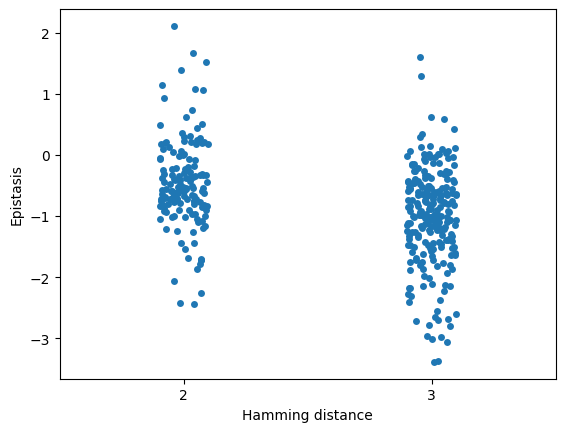

In [10]:
# make a strip plot of epistasis by hamming distance
sns.stripplot(data=two_plus_mutants_epistasis, x='hamming', y='epistasis')
plt.xlabel('Hamming distance')
plt.ylabel('Epistasis')


In [11]:
# plot a histogram of all two 

In [13]:
pd.read_excel("../../src/bio_if/data/GB1/elife-16965-supp1-v4.xlsx")

/home/cadegord/miniconda3/envs/bio-if/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Variants,HD,Count input,Count selected,Fitness
0,VDGV,0,92735,338346,1.000000
1,ADGV,1,34,43,0.061910
2,CDGV,1,850,641,0.242237
3,DDGV,1,63,63,0.006472
4,EDGV,1,841,190,0.032719
...,...,...,...,...,...
149356,YYYR,4,203,1,0.001350
149357,YYYS,4,186,3,0.004421
149358,YYYT,4,181,14,0.021200
149359,YYYW,4,30,1,0.009136
